## ML Project
#### Submitted By:
- **Niv Harel**: 208665869
- **Eytan Muzafi**: 209160308

#### Github: [https://github.com/nivrl/Machine-learning-project]

#### Imports

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import math
from geopy.geocoders import Nominatim

#### Reading and understanding the dataset

In [2]:
Behaviors= pd.read_excel("Behaviors.xlsx",index_col=0)  
Bins= pd.read_excel("Bins.xlsx",index_col=0)  
Infrastructures= pd.read_excel("Infrastructures.xlsx",index_col=0)  
Dirt_Condition= pd.read_excel("Dirt_Condition.xlsx",index_col=0)  

In [3]:
#Infrastructures.head()

In [4]:
#Dirt_Condition.head()

In [5]:
Dirt_Condition.columns.tolist()

['יישוב',
 'סמל יישוב',
 'שעת הגעה לנקודה',
 'נ.צ כתובת',
 'כתובת תיאור מיקום נקודת המדידה',
 'סוג נקודת המדידה',
 'בדלי סיגריות',
 'קופסאות סיגריות',
 'מסכות כירורגיות',
 'מכלי משקה למיניהם',
 'פקקים של מכלי משקה',
 'אריזות מזון Take Away נייר',
 'אריזות מזון Take Away פלסטיק',
 'צלחות חדפ',
 'סכום חדפ',
 'כוסות שתייה קרה חדפ',
 'כוסות שתייה חמה חדפ',
 'אריזות של חטיפים',
 'זכוכית לא מכלי משקה או לא ניתן לזיהוי',
 'נייר אחר לא אריזות מזון',
 'פלסטיק אחר שקיות פלסטיק ורכיבי פלסטיק שאינם מכלי משקה אריזות מזון ומשקאות',
 'פסולת אורגנית',
 'פסולת בלתי חוקית שקית אשפה מלאה שהושלכה ברחוב',
 'פסולת אחרת למשל בגדים סוללות חומרי פרסום וכל מה שלא קוטלג בקבוצות האחרות',
 'צואת כלבים',
 'כתמי מסטיק',
 'פריט פסולת גדול',
 'אריזות קרטון',
 'גרפיטי',
 'אחר1',
 'אחר2',
 'בנקודת המדידה נאספו x שקיות של פרטי לכלוך',
 'כמה אנשים עברו בנקודת המדידה בזמן התצפית']

In [6]:
Infrastructures.columns.tolist()

['יישוב',
 'סמל_יישוב',
 'שעתהגעהלנקודה',
 'נ.צכתובת',
 'כתובתתיאורמיקוםנקודתהמדידה',
 'התרשמותכלליתמנקודתהמדידה',
 'מדרכה',
 'אבנישפה',
 'גדרות',
 'צמחייה',
 'הערות',
 'point_type']

In [7]:
Infrastructures = Infrastructures.reset_index()
Dirt_Condition = Dirt_Condition.reset_index()
Bins = Bins.reset_index()

#### Creating dictionaries for columns renaming 

In [8]:
bins_mapping = {
    'זמן סיום מהמערכת' : 'End_Time',
    'יישוב': 'City',
    'סמל_יישוב': 'City_Code',
    'שעת הגעה לנקודה': 'Arrival_Time',
    'נ.צ כתובת': 'Coordinate_Address',
    'כתובת תיאור מיקום נקודת המדידה': 'Measurement_Point_Description',
    'סוגנ קודת המדידה': 'Point_Type',
    'האם יש פחים בנקודת המדידה': 'Has_Bins',
    'כמה פחים יש בנקודת המדידה': 'Bin_Count',
    'סוג': 'Type',
    'מצב הפח': 'Bin_Condition',
    'מפלס הפסולת בפח': 'Waste_Level',
    'מפלס הפסולת בפח במספר': 'Waste_Level_Number'
}

dirt_condition_mapping = {
    'זמן סיום מהמערכת' : 'End_Time',
    'יישוב': 'City',
    'סמל יישוב': 'City_Code',
    'שעת הגעה לנקודה': 'Arrival_Time',
    'נ.צ כתובת': 'Coordinate_Address',
    'כתובת תיאור מיקום נקודת המדידה': 'Measurement_Point_Description',
    'סוג נקודת המדידה': 'Point_Type',
    'בדלי סיגריות': 'Cigarette_Butts',
    'קופסאות סיגריות': 'Cigarette_Boxes',
    'מסכות כירורגיות': 'Surgical_Masks',
    'מכלי משקה למיניהם': 'Drink_Containers',
    'פקקים של מכלי משקה': 'Drink_Container_Caps',
    'אריזות מזון Take Away נייר': 'Paper_Takeaway_Packaging',
    'אריזות מזון Take Away פלסטיק': 'Plastic_Takeaway_Packaging',
    'צלחות חדפ': 'Disposable_Plates',
    'סכום חדפ': 'Disposable_Cutlery',
    'כוסות שתייה קרה חדפ': 'Disposable_Cold_Drink_Cups',
    'כוסות שתייה חמה חדפ': 'Disposable_Hot_Drink_Cups',
    'אריזות של חטיפים': 'Snack_Packaging',
    'זכוכית לא מכלי משקה או לא ניתן לזיהוי': 'Non_Bottle_Glass',
    'נייר אחר לא אריזות מזון': 'Other_Paper',
    'פלסטיק אחר שקיות פלסטיק ורכיבי פלסטיק שאינם מכלי משקה אריזות מזון ומשקאות': 'Other_Plastic',
    'פסולת אורגנית': 'Organic_Waste',
    'פסולת בלתי חוקית שקית אשפה מלאה שהושלכה ברחוב': 'Illegal_Dumping',
    'פסולת אחרת למשל בגדים סוללות חומרי פרסום וכל מה שלא קוטלג בקבוצות האחרות': 'Other_Waste',
    'צואת כלבים': 'Dog_Feces',
    'כתמי מסטיק': 'Gum_Stains',
    'פריט פסולת גדול': 'Large_Waste_Item',
    'אריזות קרטון': 'Cardboard_Packaging',
    'גרפיטי': 'Graffiti',
    'אחר1': 'Other1',
    'אחר2': 'Other2',
    'בנקודת המדידה נאספו x שקיות של פרטי לכלוך': 'Bags_Collected',
    'כמה אנשים עברו בנקודת המדידה בזמן התצפית': 'People_Passed_During_Observation'
}

infrastructures_mapping = {
    'זמןסיוםמהמערכת' : 'End_Time',
    'יישוב': 'City',
    'סמל_יישוב': 'City_Code',
    'שעתהגעהלנקודה': 'Arrival_Time',
    'נ.צכתובת': 'Coordinate_Address',
    'כתובתתיאורמיקוםנקודתהמדידה': 'Measurement_Point_Description',
    'התרשמותכלליתמנקודתהמדידה': 'General_Impression',
    'מדרכה': 'Sidewalk',
    'אבנישפה': 'Curb',
    'גדרות': 'Fences',
    'צמחייה': 'Vegetation',
    'הערות': 'Remarks',
    'point_type': 'Point_Type'
}



In [9]:
bins_renamed = Bins.rename(columns=bins_mapping)
dirt_condition_renamed = Dirt_Condition.rename(columns=dirt_condition_mapping)
infrastructures_renamed = Infrastructures.rename(columns=infrastructures_mapping)

In [10]:
#bins_renamed

### First Data Cleaning & Organizing 

Take the relevant columns for each DF

In [11]:
bins_df = bins_renamed[['City_Code','Measurement_Point_Description', 'Point_Type','Bin_Count','Has_Bins','End_Time']]
dirt_condition_df = dirt_condition_renamed.drop(['Arrival_Time','Coordinate_Address','Other1','Other2'], axis=1)
infrastructures_df = infrastructures_renamed.drop(['City', 'Arrival_Time','Coordinate_Address','Remarks'], axis=1)

#### Organizing the PKs for later merge: date, Measurement_Point_Description

In [12]:
bins_df['Measurement_Point_Description'] = bins_df['Measurement_Point_Description'].str.replace(r'[A-Za-z0-9_\n]', '', regex=True)
dirt_condition_df['Measurement_Point_Description'] = dirt_condition_df['Measurement_Point_Description'].str.replace(r'[A-Za-z0-9_\n]', '', regex=True)
infrastructures_df['Measurement_Point_Description'] = infrastructures_df['Measurement_Point_Description'].str.replace(r'[A-Za-z0-9_\n]', '', regex=True)

<ipython-input-12-b5f7f3d4bada>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins_df['Measurement_Point_Description'] = bins_df['Measurement_Point_Description'].str.replace(r'[A-Za-z0-9_\n]', '', regex=True)


In [13]:
infrastructures_df['End_Time'] = pd.to_datetime(infrastructures_df['End_Time'])
infrastructures_df['Date'] = infrastructures_df['End_Time'].dt.date

dirt_condition_df['End_Time'] = pd.to_datetime(dirt_condition_df['End_Time'])
dirt_condition_df['Date'] = dirt_condition_df['End_Time'].dt.date

bins_df['End_Time'] = pd.to_datetime(bins_df['End_Time'])
bins_df['Date'] = bins_df['End_Time'].dt.date

<ipython-input-13-16fb29a9e75f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins_df['End_Time'] = pd.to_datetime(bins_df['End_Time'])
<ipython-input-13-16fb29a9e75f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins_df['Date'] = bins_df['End_Time'].dt.date


##### Handling Nulls (pre condition for merging the DFs) - Only for bin_count and has_bins

In [14]:
avg_bin_count_per_city = (
    bins_df
    .groupby(['City_Code'], as_index=False)
    .agg({'Bin_Count': 'mean'}) ## add avg count of gerbege
)
avg_bin_count_per_city.Bin_Count = avg_bin_count_per_city.Bin_Count.fillna(avg_bin_count_per_city.Bin_Count.mean())

In [15]:
avg_bin_count_per_city['Bin_Count'] = avg_bin_count_per_city['Bin_Count'].apply(
    lambda x: math.ceil(x) if x - int(x) > 0.5 else math.floor(x))

In [16]:
avg_bin_count_per_city

,City_Code,Bin_Count
0,2,2
1,8,3
2,12,4
3,29,7
4,31,3
...,...,...
75,8500,1
76,8800,2
77,9000,8
78,9200,3


In [17]:
bins_df['Fixed_Bin_Count'] = bins_df['Bin_Count'].combine_first(bins_df['City_Code'].map(
    avg_bin_count_per_city.set_index('City_Code')['Bin_Count']))

<ipython-input-17-829e0f23dc2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins_df['Fixed_Bin_Count'] = bins_df['Bin_Count'].combine_first(bins_df['City_Code'].map(


In [18]:
# bins_df

In [19]:
bins_df = (
    bins_df
    .groupby(['City_Code', 'Measurement_Point_Description', 'Point_Type', 'End_Time','Date'], as_index=False)
    .agg({'Has_Bins': 'max','Fixed_Bin_Count': 'mean'}) 
)

In [20]:
bins_df['Bin_Count'] = bins_df['Fixed_Bin_Count'].apply(
    lambda x: math.ceil(x) if x - int(x) > 0.5 else math.floor(x))

In [21]:
# bins_df.head(20)

#### Merging DFs with inner joins 

In [22]:
merged_df = pd.merge(infrastructures_df, dirt_condition_df, on=[
    "City_Code", "Measurement_Point_Description", "Date"], how='inner')	

In [23]:
merged_df.shape

(1478, 38)

In [24]:
full_merged_df = pd.merge(merged_df, bins_df, on=
                          ["City_Code", "Measurement_Point_Description", "Date"], how='inner')	

In [25]:
relevant_columns = ['End_Time_x', 'Date', 'City', 'City_Code', 'Measurement_Point_Description', 'Point_Type_x',
       'Cigarette_Butts', 'Cigarette_Boxes', 'Surgical_Masks', 'Drink_Containers',
       'Drink_Container_Caps', 'Paper_Takeaway_Packaging',
       'Plastic_Takeaway_Packaging', 'Disposable_Plates', 'Disposable_Cutlery',
       'Disposable_Cold_Drink_Cups', 'Disposable_Hot_Drink_Cups',
       'Snack_Packaging', 'Non_Bottle_Glass', 'Other_Paper', 'Other_Plastic',
       'Organic_Waste', 'Illegal_Dumping', 'Other_Waste', 'Dog_Feces',
       'Gum_Stains', 'Large_Waste_Item', 'Cardboard_Packaging', 'Graffiti',
       'Bags_Collected', 'People_Passed_During_Observation', 'Has_Bins','Bin_Count',
       'General_Impression', 'Sidewalk', 'Curb', 'Fences', 'Vegetation']

full_merged_df = full_merged_df[relevant_columns]

In [26]:
full_merged_df.rename(columns=lambda col: col[:-2] if col.endswith('_x') else col, inplace=True)
full_merged_df.head()

,End_Time,Date,City,City_Code,Measurement_Point_Description,Point_Type,Cigarette_Butts,Cigarette_Boxes,Surgical_Masks,Drink_Containers,...,Graffiti,Bags_Collected,People_Passed_During_Observation,Has_Bins,Bin_Count,General_Impression,Sidewalk,Curb,Fences,Vegetation
0,2021-07-07 10:22:27,2021-07-07,רמלה,8500,רחוב זכריה,רחוב מגורים,2,4,0,0,...,0,1.0,7,לא,1,3,סביר,סביר,סביר,סביר
1,2021-07-08 13:43:58,2021-07-08,מגדל העמק,874,מגדל העמק רחוב הזית,רחוב מסחרי,900,30,100,55,...,0,7.0,300,לא,4,4,לא תקין (מוזנח),לא תקין (מוזנח),לא רלוונטי,לא תקין (מוזנח)
2,2021-07-08 15:29:42,2021-07-08,מגדל העמק,874,רחוב הראשונים - שוק,רחוב מסחרי,100,3,15,5,...,0,5.0,125,לא,4,4,תקין (מטופח),תקין (מטופח),תקין (מטופח),לא רלוונטי
3,2021-07-08 18:29:40,2021-07-08,מגדל העמק,874,רחוב בוסקילה פארק משחקים (שניים סמוכים),פנאי ונופש,53,2,12,30,...,0,2.0,73,לא,4,2,תקין (מטופח),תקין (מטופח),תקין (מטופח),לא רלוונטי
4,2021-07-08 20:25:47,2021-07-08,מגדל העמק,874,פארק הראשונים - פנאי ונופש,פנאי ונופש,999,8,8,7,...,15,2.0,212,לא,4,3,תקין (מטופח),תקין (מטופח),תקין (מטופח),תקין (מטופח)


#### Fetching dtypes

In [27]:
full_merged_df['Date'] = pd.to_datetime(full_merged_df['Date'])
full_merged_df['Has_Bins'] = full_merged_df['Has_Bins'].replace('כן', True)
full_merged_df['Has_Bins'] = full_merged_df['Has_Bins'].replace('לא', False)

In [28]:
full_merged_df.dtypes

End_Time                            datetime64[ns]
Date                                datetime64[ns]
City                                        object
City_Code                                    int64
Measurement_Point_Description               object
Point_Type                                  object
Cigarette_Butts                              int64
Cigarette_Boxes                              int64
Surgical_Masks                               int64
Drink_Containers                             int64
Drink_Container_Caps                         int64
Paper_Takeaway_Packaging                     int64
Plastic_Takeaway_Packaging                   int64
Disposable_Plates                            int64
Disposable_Cutlery                           int64
Disposable_Cold_Drink_Cups                   int64
Disposable_Hot_Drink_Cups                    int64
Snack_Packaging                              int64
Non_Bottle_Glass                             int64
Other_Paper                    

In [29]:
for col in full_merged_df.columns:
    if col not in ['Measurement_Point_Description', 'Point_Type']:
        if full_merged_df[col].dtype not in ['int64', 'float64', 'datetime64[ns]']:
            full_merged_df[col] = full_merged_df[col].astype('category')

In [30]:
full_merged_df.dtypes

End_Time                            datetime64[ns]
Date                                datetime64[ns]
City                                      category
City_Code                                    int64
Measurement_Point_Description               object
Point_Type                                  object
Cigarette_Butts                              int64
Cigarette_Boxes                              int64
Surgical_Masks                               int64
Drink_Containers                             int64
Drink_Container_Caps                         int64
Paper_Takeaway_Packaging                     int64
Plastic_Takeaway_Packaging                   int64
Disposable_Plates                            int64
Disposable_Cutlery                           int64
Disposable_Cold_Drink_Cups                   int64
Disposable_Hot_Drink_Cups                    int64
Snack_Packaging                              int64
Non_Bottle_Glass                             int64
Other_Paper                    

In [31]:
full_merged_df.to_excel('full_merged_df.xlsx', index=False)

### Handling the rest of the Nulls & Outlires

In [57]:
df= pd.read_excel("full_merged_df.xlsx") 

In [58]:
df.head()

,End_Time,Date,City,City_Code,Measurement_Point_Description,Point_Type,Cigarette_Butts,Cigarette_Boxes,Surgical_Masks,Drink_Containers,...,Graffiti,Bags_Collected,People_Passed_During_Observation,Has_Bins,Bin_Count,General_Impression,Sidewalk,Curb,Fences,Vegetation
0,2021-07-07 10:22:27,2021-07-07,רמלה,8500,רחוב זכריה,רחוב מגורים,2,4,0,0,...,0,1.0,7,False,1,3,סביר,סביר,סביר,סביר
1,2021-07-08 13:43:58,2021-07-08,מגדל העמק,874,מגדל העמק רחוב הזית,רחוב מסחרי,900,30,100,55,...,0,7.0,300,False,4,4,לא תקין (מוזנח),לא תקין (מוזנח),לא רלוונטי,לא תקין (מוזנח)
2,2021-07-08 15:29:42,2021-07-08,מגדל העמק,874,רחוב הראשונים - שוק,רחוב מסחרי,100,3,15,5,...,0,5.0,125,False,4,4,תקין (מטופח),תקין (מטופח),תקין (מטופח),לא רלוונטי
3,2021-07-08 18:29:40,2021-07-08,מגדל העמק,874,רחוב בוסקילה פארק משחקים (שניים סמוכים),פנאי ונופש,53,2,12,30,...,0,2.0,73,False,4,2,תקין (מטופח),תקין (מטופח),תקין (מטופח),לא רלוונטי
4,2021-07-08 20:25:47,2021-07-08,מגדל העמק,874,פארק הראשונים - פנאי ונופש,פנאי ונופש,999,8,8,7,...,15,2.0,212,False,4,3,תקין (מטופח),תקין (מטופח),תקין (מטופח),תקין (מטופח)


In [59]:
len(df.City.unique())

77

In [60]:
df.columns

Index(['End_Time', 'Date', 'City', 'City_Code',
       'Measurement_Point_Description', 'Point_Type', 'Cigarette_Butts',
       'Cigarette_Boxes', 'Surgical_Masks', 'Drink_Containers',
       'Drink_Container_Caps', 'Paper_Takeaway_Packaging',
       'Plastic_Takeaway_Packaging', 'Disposable_Plates', 'Disposable_Cutlery',
       'Disposable_Cold_Drink_Cups', 'Disposable_Hot_Drink_Cups',
       'Snack_Packaging', 'Non_Bottle_Glass', 'Other_Paper', 'Other_Plastic',
       'Organic_Waste', 'Illegal_Dumping', 'Other_Waste', 'Dog_Feces',
       'Gum_Stains', 'Large_Waste_Item', 'Cardboard_Packaging', 'Graffiti',
       'Bags_Collected', 'People_Passed_During_Observation', 'Has_Bins',
       'Bin_Count', 'General_Impression', 'Sidewalk', 'Curb', 'Fences',
       'Vegetation'],
      dtype='object')

### Nulls Handling Division:

### Niv - 
['End_Time', 'Date', 'City', 'City_Code',
       'Measurement_Point_Description', 'Point_Type', 'Cigarette_Butts',
       'Cigarette_Boxes', 'Surgical_Masks', 'Drink_Containers',
       'Drink_Container_Caps', 'Paper_Takeaway_Packaging',
       'Plastic_Takeaway_Packaging', 'Disposable_Plates', 'Disposable_Cutlery',
       'Disposable_Cold_Drink_Cups', 'Disposable_Hot_Drink_Cups',
       'Snack_Packaging', 'Non_Bottle_Glass', 'Other_Paper', 'Other_Plastic']
       
### Mutzafi - 
['Organic_Waste', 'Illegal_Dumping', 'Other_Waste', 'Dog_Feces',
       'Gum_Stains', 'Large_Waste_Item', 'Cardboard_Packaging', 'Graffiti',
       'Bags_Collected', 'People_Passed_During_Observation', 'Has_Bins',
       'Bin_Count', 'General_Impression', 'Sidewalk', 'Curb', 'Fences',
       'Vegetation']


In [61]:
numeric_cols = ['Cigarette_Butts', 'Cigarette_Boxes', 'Surgical_Masks', 'Drink_Containers', 'Drink_Container_Caps', 'Paper_Takeaway_Packaging', 'Plastic_Takeaway_Packaging', 'Disposable_Plates', 'Disposable_Cutlery', 'Disposable_Cold_Drink_Cups', 'Disposable_Hot_Drink_Cups', 'Snack_Packaging', 'Non_Bottle_Glass', 'Other_Paper', 'Other_Plastic']

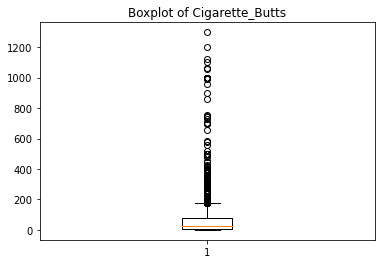

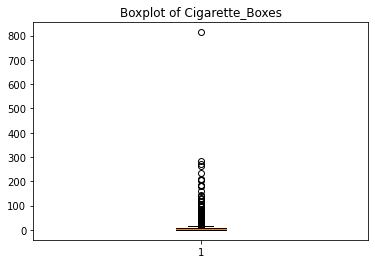

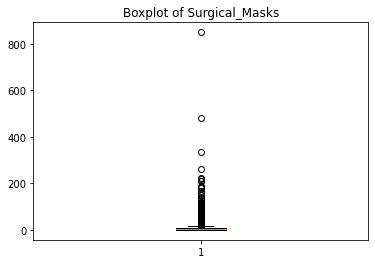

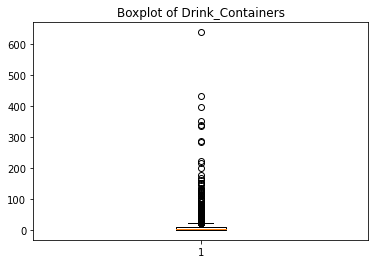

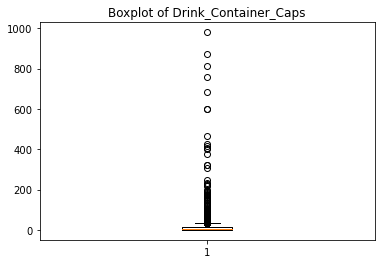

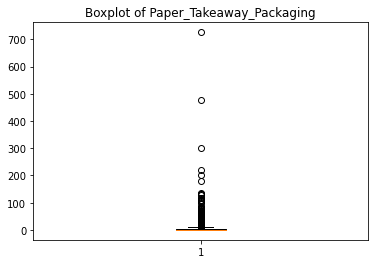

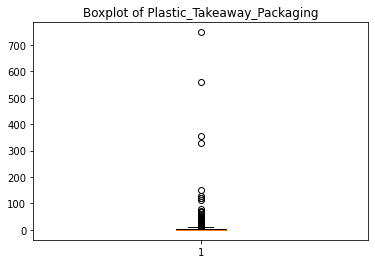

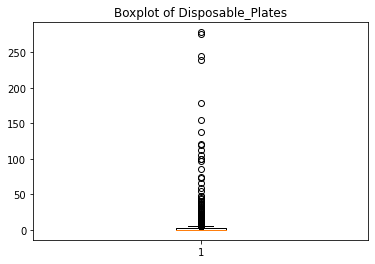

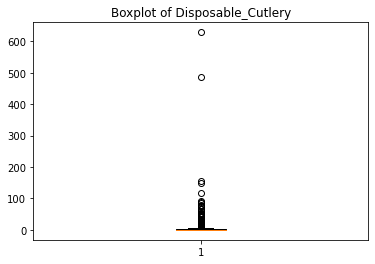

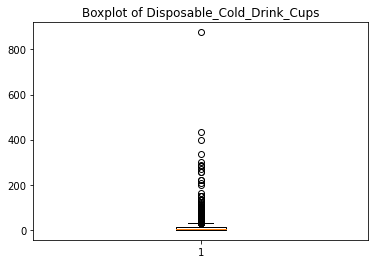

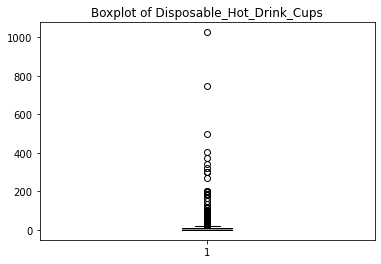

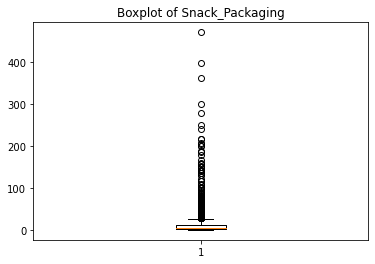

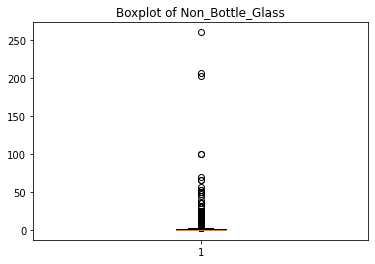

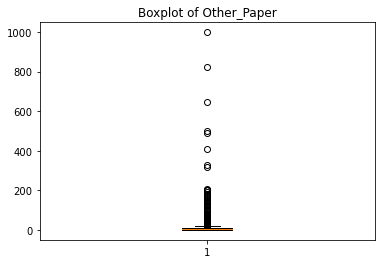

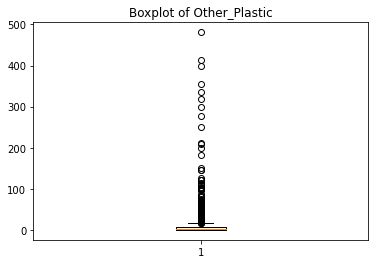

In [62]:
## Examining Outlieres
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show() ## Need to be normalized with generic function

In [63]:
## Dates Fetching
df['Day_Of_Week'] = df.Date.dt.day
df['Month'] = df.Date.dt.month

df = df.drop(['End_Time', 'Date'], axis=1)
df[['Month', 'Day_Of_Week']] = df[['Month', 'Day_Of_Week']] = df[['Month', 'Day_Of_Week']].astype('category')

## Fetching Point_type
df[['Point_Type']] = df[['Point_Type']] = df[['Point_Type']].astype('category')


In [64]:
len(df)

1626

In [70]:
## City Fetching - Avoiding OverFitting
economical_status = pd.read_excel("economical_status.xlsx")  
economical_status = economical_status[economical_status['Unnamed: 2'].notnull()].reset_index()
economical_status = economical_status.iloc[1:, [2, 7, 9]]
columns_rename_e = ['City_Code','Area_code', 'Economical_Rate']
economical_status.columns = columns_rename_e
economical_status['Economical_Rate'] = economical_status['Economical_Rate'].astype('Float64')
economical_status = economical_status.groupby(['City_Code'], as_index=False).agg({'Economical_Rate': 'mean'})
economical_status

,City_Code,Economical_Rate
0,31,-0.869768
1,70,-0.236784
2,166,0.78359
3,168,0.79368
4,195,1.204407
...,...,...
76,9400,0.937315
77,9500,0.395968
78,9600,-0.437139
79,9700,1.516564


In [71]:
## City Fetching - Avoiding OverFitting
location_rank = pd.read_excel("location_rank.xlsx")  
location_rank = location_rank.iloc[6:, [3, 9]]
columns_rename_l = ['City_Code','Location_Rate']
location_rank.columns = columns_rename_l
location_rank['Location_Rate'] = location_rank['Location_Rate'].astype('Float64')
location_rank = location_rank.groupby(['City_Code'], as_index=False).agg({'Location_Rate': 'mean'})
location_rank

,City_Code,Location_Rate
0,7,0.423495
1,10,0.671894
2,11,0.43653
3,13,-2.36083
4,15,0.37492
...,...,...
1208,9400,1.452423
1209,9500,-0.235317
1210,9600,-0.225262
1211,9700,1.352605


In [72]:
## City Fetching - Avoiding OverFitting
df = pd.merge(df, economical_status, on=[
    "City_Code"], how='inner')
df = pd.merge(df, location_rank, on=[
    "City_Code"], how='inner')

In [73]:
len(df)

997

In [81]:
## Street Fetching - Avoiding OverFitting 
def classify_street(street):
    if any(keyword in street for keyword in ['דיין', 'הרצל', 'גוריון', 'רוטשילד', 'בגין', 'דיזינגוף']):
        return 'Main'
    if any(keyword in street for keyword in ['פארק', 'גן']):
        return 'Park'
    if any(keyword in street for keyword in ['קניון', 'מרכז מסחרי', 'שוק']):
        return 'Commercial'
    if any(keyword in street for keyword in ['תחנת דלק', 'תחנת רכבת']):
        return 'Transportation'
    if any(keyword in street for keyword in ['בית ספר', 'מתנ"ס', 'קופת חולים']):
        return 'Public Facility'
    if any(keyword in street for keyword in [
    'מכללת' , 'שדרה', 'דרך', 'מרכז', 'מכללה', 'טיילת', 'כיכר']):  
        return 'Popular'
    return 'Other'

df['Street_Group'] = df['Measurement_Point_Description'].apply(lambda x: classify_street(x))

df.head()

,City,City_Code,Measurement_Point_Description,Point_Type,Cigarette_Butts,Cigarette_Boxes,Surgical_Masks,Drink_Containers,Drink_Container_Caps,Paper_Takeaway_Packaging,...,General_Impression,Sidewalk,Curb,Fences,Vegetation,Day_Of_Week,Month,Economical_Rate,Location_Rate,Street_Group
0,רמלה,8500,רחוב זכריה,רחוב מגורים,2,4,0,0,0,4,...,3,סביר,סביר,סביר,סביר,7,7,-0.535233,1.272301,Other
1,רמלה,8500,בן גוריון,רחוב מגורים,5,3,1,3,0,0,...,3,לא תקין (מוזנח),סביר,סביר,לא תקין (מוזנח),12,7,-0.535233,1.272301,Main
2,רמלה,8500,רחוב בן צבי,רחוב מגורים,20,3,2,0,10,0,...,2,תקין (מטופח),סביר,תקין (מטופח),לא תקין (מוזנח),12,7,-0.535233,1.272301,Other
3,רמלה,8500,יהודה שטיין כיכר גיבורי ישראל,רחוב מגורים,95,16,10,11,11,5,...,2,תקין (מטופח),סביר,לא תקין (מוזנח),תקין (מטופח),12,7,-0.535233,1.272301,Popular
4,רמלה,8500,רחוב הצנחנים,רחוב מגורים,25,2,7,4,2,1,...,4,לא תקין (מוזנח),סביר,תקין (מטופח),לא תקין (מוזנח),13,7,-0.535233,1.272301,Other


In [82]:
df['Street_Group'].value_counts() ## Maybe delete most of the others.. We can handle data of 300-400 rows 
## ( by hajaj it need to be greater than 100..)

Other              695
Park               106
Commercial         106
Popular             52
Main                22
Public Facility     13
Transportation       3
Name: Street_Group, dtype: int64